# Make ESM embs of entire reviewed Unirpot

---

In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

import sys
import os
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.embeddings_functions as my_embs
import utils.dataset as my_dataset
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.decomposition import PCA


import torch
import random
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print(torch.__version__)

Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
2.5.0+cu121


In [2]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)
    "BATCH_SIZE": 16,

    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "PRETRAIN_ESM_CHECKPOINT_NAME": 
        #"facebook/esm2_t48_15B_UR50D", 
        "facebook/esm2_t36_3B_UR50D",
        # #"facebook/esm2_t33_650M_UR50D", 
        # #"facebook/esm2_t12_35M_UR50D", 
        # #"facebook/esm2_t6_8M_UR50D", 

    "UNIPROT_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv"
}
config["PRECOMPUTED_EMBS_PATH"] = os.path.join(
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
print(config["PRECOMPUTED_EMBS_PATH"])
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')
config["PRECOMPUTED_EMBS_PATH_ADATA"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '.h5ad')


# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors


---

## Instantiate ESM model

In [5]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(
    config["PRETRAIN_ESM_CHECKPOINT_NAME"], 
    cache_dir=config["PRETRAIN_ESM_CACHE_DIR"],
    weights_only=False  
).to(config["DEVICE"]) 

# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



## Load dataset and Tokenize

In [6]:
uniprot_proteome = pd.read_csv(config["UNIPROT_PATH"], sep="\t")

# only reviewd
uniprot_proteome = uniprot_proteome[uniprot_proteome.Reviewed == "reviewed"]

#data = data.head(10)

# Remae
uniprot_proteome = uniprot_proteome.rename(columns={"Entry": "protein", "Sequence": "sequence", "Gene Names (primary)": "gene"})

# For Later
num_samples = uniprot_proteome.shape[0]
emb_dim = esm_model.config.hidden_size
print(num_samples, emb_dim)

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
uniprot_proteome["truncated_sequence"] = uniprot_proteome.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
print("Tokenizing...")
encoded = tokenizer(
    list(uniprot_proteome.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(uniprot_proteome.protein),
    'sequence': list(uniprot_proteome.sequence),
    'truncated_sequence': list(uniprot_proteome.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
    'embedding': torch.zeros((num_samples, 1), dtype=torch.float32), # FAKE
    'label': torch.zeros((num_samples, 1), dtype=torch.float32), # FAKE
    'set': torch.zeros((num_samples, 1), dtype=torch.float32), # FAKE
}


20405 2560
Tokenizing...


## Create embs


In [ ]:
# my_dataset.create_uniprot_embs(
#     esm_model,
#     config, 
#     cache_data, 
#     num_samples, 
#     emb_dim
#     save_embs_path=config["PRECOMPUTED_EMBS_PATH"],
#     save_names_path=config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"],
# )

# Create AnnData with protein embs

## How to Load Embeddings in Downstream Scripts


In [3]:
embs, protein_names_selected = my_dataset.load_embs_safetensor(
    precomputed_embs_path=config["PRECOMPUTED_EMBS_PATH"], # path with tensors
    protein_names_path=config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json'), # path with the prtein names of the tenoser
    protein_to_select=None # take all
    )
embs

Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors
✓ Mapped 20405 embeddings (shape: torch.Size([20405, 2560]))
✓ Loaded 20405 / 20405 embeddings
  Shape: torch.Size([20405, 2560])
  Memory: 199.3 MB


tensor([[-3.8923e-02,  1.6107e-02, -7.6490e-02,  ...,  1.2858e-01,
         -3.7806e-02, -3.7085e-02],
        [-1.0678e-02, -1.0572e-02, -9.9035e-02,  ...,  1.1212e-01,
         -8.4403e-02, -1.1259e-01],
        [-9.1889e-05, -3.7981e-02, -6.9931e-02,  ...,  7.1133e-02,
          3.0236e-02, -1.2470e-01],
        ...,
        [-3.0047e-02, -4.4904e-03, -8.9991e-02,  ...,  7.8647e-02,
         -7.0830e-04, -9.1883e-02],
        [-7.8413e-03, -4.0240e-02, -9.5876e-02,  ...,  9.4554e-02,
         -1.3451e-02, -8.7127e-02],
        [ 9.3950e-04, -2.5874e-02, -9.8008e-02,  ...,  7.7112e-02,
         -3.5783e-02, -1.1824e-01]])

## Create Protein anndata

X --> toekn IDs of truncated protein

obsm[X_latent]

obsm[X_pca]

uns[vocabulary] --> Id to aa mapping

obs: copy from uniprot_proteim.tsv


In [ ]:
# # Read matrix
# adata = sc.AnnData(embs.cpu().numpy()) # Transpose to get Prot x dims

# # Assign protein anmes names
# adata.obs_names = protein_names_selected
# #adata.var_names = genes.gene.astype(str)

# adata.obsm["input_ids"] = input_ids_tensor.cpu().numpy()
# adata.obsm["attention_mask"] = attention_mask_tensor.cpu().numpy()

# adata.obs = adata.obs.merge(uniprot_proteome, left_index=True, right_on="protein", how="left")
# adata.uns["vocabulary"] = tokenizer.get_vocab()


# print(adata)
# display(adata.obs)

In [7]:
# Read matrix
adata = sc.AnnData(input_ids_tensor.cpu().numpy()) # Transpose to get Prot x dims

# Assign protein anmes names
adata.obs_names = protein_names_selected
#adata.var_names = genes.gene.astype(str)

adata.obsm["X_all"] = embs.cpu().numpy()
adata.layers["attention_mask"] = attention_mask_tensor.cpu().numpy()

adata.obs = adata.obs.merge(uniprot_proteome, left_index=True, right_on="protein", how="left", validate="1:1")
adata.obs.set_index("protein", drop=False)
adata.uns["vocabulary"] = { #  problem with serialization
    str(k).replace('-', 'DASH').replace('.', 'DOT'): str(v) 
    for k, v in tokenizer.get_vocab().items()
}

print(adata)
display(adata.obs)

AnnData object with n_obs × n_vars = 20405 × 1000
    obs: 'protein', 'gene', 'Reviewed', 'Gene Names', 'Organism', 'Length', 'Protein names', 'sequence', 'truncated_sequence'
    uns: 'vocabulary'
    obsm: 'X_all'
    layers: 'attention_mask'


/home/gdallagl/.pyenv/versions/3.11.8/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,protein,gene,Reviewed,Gene Names,Organism,Length,Protein names,sequence,truncated_sequence
0,A0A087X1C5,CYP2D7,reviewed,CYP2D7,Homo sapiens (Human),515,Cytochrome P450 2D7 (EC 1.14.14.1),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
1,A0A0B4J2F0,PIGBOS1,reviewed,PIGBOS1,Homo sapiens (Human),54,Protein PIGBOS1 (PIGB opposite strand protein 1),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
2,A0A0C5B5G6,MT-RNR1,reviewed,MT-RNR1,Homo sapiens (Human),16,Mitochondrial-derived peptide MOTS-c (Mitochon...,MRWQEMGYIFYPRKLR,MRWQEMGYIFYPRKLR
3,A0A0K2S4Q6,CD300H,reviewed,CD300H,Homo sapiens (Human),201,Protein CD300H (CD300 antigen-like family memb...,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...
4,A0A0U1RRE5,NBDY,reviewed,NBDY LINC01420,Homo sapiens (Human),68,Negative regulator of P-body association (P-bo...,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...
...,...,...,...,...,...,...,...,...,...
20400,Q9UI25,NaN,reviewed,PRO0461,Homo sapiens (Human),63,Putative uncharacterized protein PRO0461,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...
20401,Q9UI54,NaN,reviewed,PRO0628,Homo sapiens (Human),55,Putative uncharacterized protein PRO0628,MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...,MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...
20402,Q9UI72,NaN,reviewed,PRO0255,Homo sapiens (Human),69,Putative uncharacterized protein PRO0255,MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...,MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...
20403,Q9Y3F1,NaN,reviewed,NaN,Homo sapiens (Human),56,Putative TAP2-associated 6.5 kDa polypeptide,MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...,MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...


## Compute PCA

Before: (20405, 200)
After: (20405, 27)
To explain 50% of variance, keep 27 PCs.


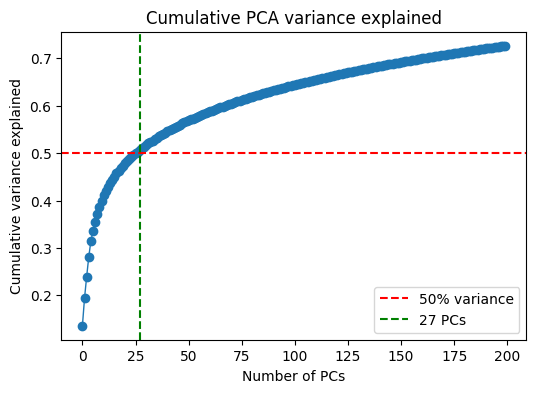

In [8]:
# --- PARAMETERS ---
N_PCs = 200                # max number of components to compute
threshold = 0.5            # desired cumulative variance explained (e.g. 50%)

# --- RUN PCA ---
X = adata.obsm["X_all"]  # attention use ESM latntespace
pca = PCA(n_components=N_PCs, random_state=42, svd_solver="arpack")
adata.obsm["X_pca"] = pca.fit_transform(X)

# --- STORE PCA METADATA (like Scanpy does) ---
adata.uns["pca"] = {}
adata.uns["pca"]["variance"] = pca.explained_variance_.copy()
adata.uns["pca"]["variance_ratio"] = pca.explained_variance_ratio_.copy()

# --- COMPUTE CUMULATIVE VARIANCE ---
var_ratio = pca.explained_variance_ratio_
cumulative = np.cumsum(var_ratio)

# --- FIND MINIMUM NUMBER OF PCs REACHING THRESHOLD ---
n_pcs_optimal = np.argmax(cumulative >= threshold) + 1

# --- SUBSET PCA EMBEDDINGS ---
print("Before:", adata.obsm["X_pca"].shape)
adata.obsm["X_pca"] = adata.obsm["X_pca"][:, :n_pcs_optimal]
print("After:", adata.obsm["X_pca"].shape)

print(f"To explain {threshold*100:.0f}% of variance, keep {n_pcs_optimal} PCs.")

# --- PLOT CUMULATIVE VARIANCE ---
plt.figure(figsize=(6,4))
plt.plot(cumulative, marker='o', lw=1)
plt.axhline(y=threshold, color='r', ls='--', label=f'{threshold*100:.0f}% variance')
plt.axvline(x=n_pcs_optimal, color='g', ls='--', label=f'{n_pcs_optimal} PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative PCA variance explained')
plt.legend()
plt.show()


## Compute Umaps

Calculating Neightbors...
Calculating Umaps...


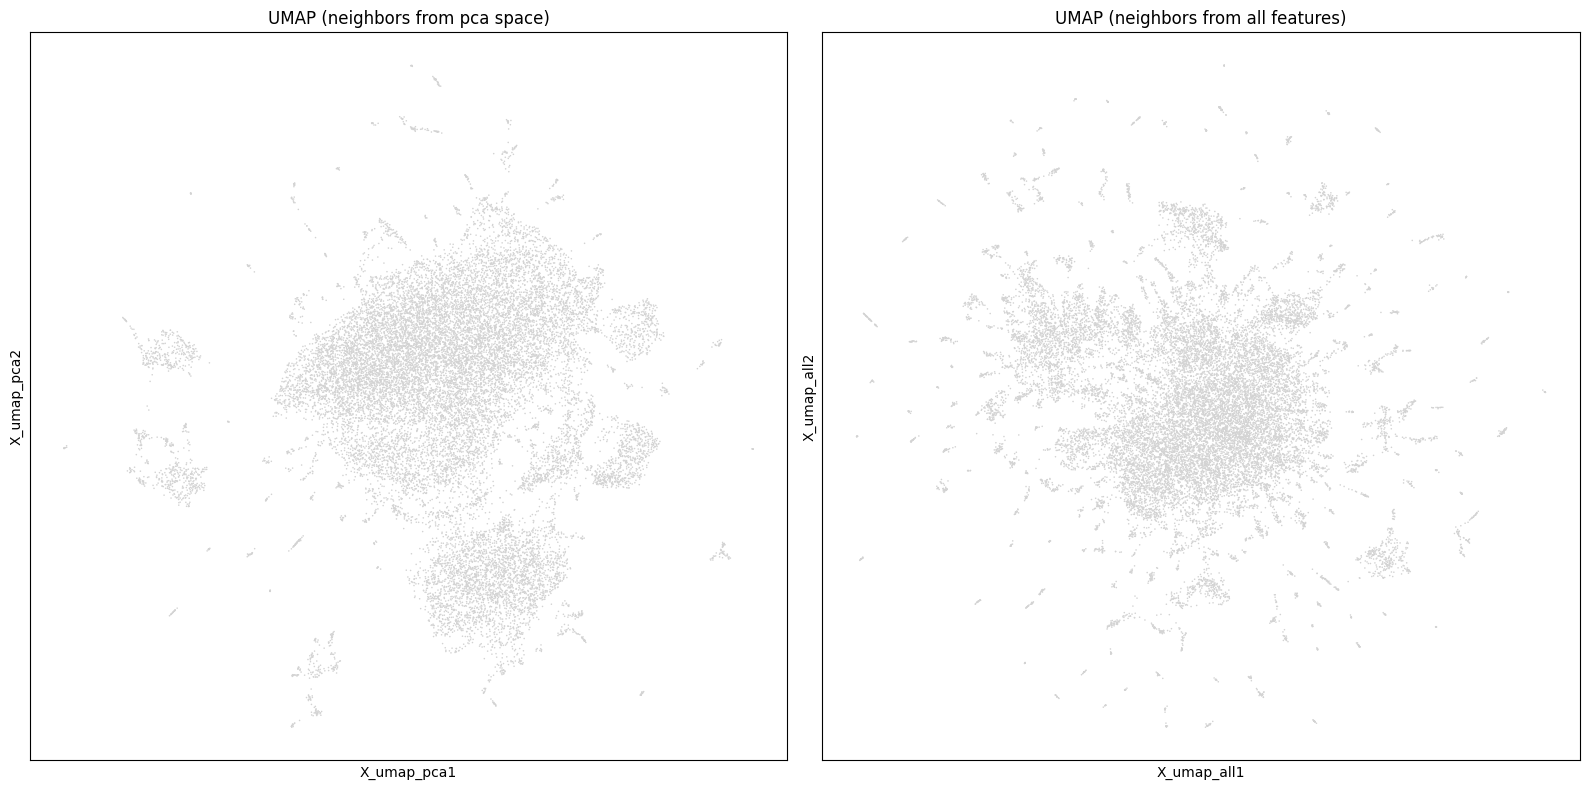

AnnData object with n_obs × n_vars = 20405 × 1000
    obs: 'protein', 'gene', 'Reviewed', 'Gene Names', 'Organism', 'Length', 'Protein names', 'sequence', 'truncated_sequence'
    uns: 'vocabulary', 'pca', 'neighbors_pca', 'neighbors_all', 'X_umap_pca', 'X_umap_all'
    obsm: 'X_all', 'X_pca', 'X_umap_pca', 'X_umap_all'
    layers: 'attention_mask'
    obsp: 'neighbors_pca_distances', 'neighbors_pca_connectivities', 'neighbors_all_distances', 'neighbors_all_connectivities'

In [9]:
# --- Neighbors ---
print("Calculating Neightbors...")
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=10, n_pcs=n_pcs_optimal, key_added="neighbors_pca") # overwirtes previosn grpah
sc.pp.neighbors(adata, use_rep="X_all", n_neighbors=10, key_added="neighbors_all")# Use raw adata.X

# --- UMAPs ---
print("Calculating Umaps...")
sc.tl.umap(adata, random_state=42, neighbors_key="neighbors_pca", key_added="X_umap_pca") # each time overweites X_umap
sc.tl.umap(adata, random_state=42, neighbors_key="neighbors_all", key_added="X_umap_all") # each time overweites X_umap

# ATTENTION:  if those 100 PCs already capture >99% of variance, the neighbor graphs will be nearly identical


fig, axes = my_embs.plot_embeddings(
    adata,
    basis=["X_umap_pca", "X_umap_all"],
    color=[None],
    title=["UMAP (neighbors from pca space)", "UMAP (neighbors from all features)"],
    size=[5],
    #palette=[None, "tab20", "viridis"],
    ncols=2,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data']
)
plt.show()

adata 

## Save Adata

In [10]:
adata.write_h5ad(config["PRECOMPUTED_EMBS_PATH_ADATA"])

---
---

# Multiple step clusterign ("Centeral Splatter")

In [ ]:
adata = my_dataset.add_dbscan_clustering(
    adata, 
    basis='X_pca', 
    eps=0.3,           
    min_samples=5,
    key_added='dbscan_PCA'
)


fig, axes = plt.subplots(1, 2, figsize=(30, 15)) # Adjust figsize as needed
sc.pl.embedding(
    adata,
    basis="X_umap_PCA",
    color="dbscan_PCA",
    legend_loc='on data',
    palette=big_palette,
    ax=axes[0],
    size=30,
    show=False,
)
sc.pl.embedding(
    adata,
    basis="X_umap_PCA",
    color="dbscan_PCA",
    legend_loc='on data',
    palette=big_palette,
    ax=axes[1],
    size=30,
    groups=["Noise"],
    show=False,
)
plt.tight_layout()
plt.show()

In [ ]:
# #sns.clustermap(adata.obsm["X_pca"][:,:20])

# sns.clustermap(
#     adata.obsm["X_pca"][:,:20],
#     method='ward',      # Agglomerative clustering linkage method
#     metric='euclidean', # Distance metric for clustering
#     z_score=0,          # Scale the data by rows (0) or columns (1)
#     cmap='viridis',     # Color map for the heatmap
#     figsize=(10, 10),   # Size of the entire figure
#     dendrogram_ratio=(.1, .2), # Space for the dendrograms (row, column)
#     cbar_pos=(0.02, 0.8, 0.03, 0.18), # Position of the color bar (left, bottom, width, height)
#     col_cluster=False,  # Optional: Often False for PC features
# )

In [ ]:
CLUSTER = str(30)

fig, axes = plt.subplots(1, 1, figsize=(15, 7)) # Adjust figsize as needed
sc.pl.embedding(
    adata,
    basis="X_umap_PCA",
    color="dbscan_PCA",
    legend_loc='on data',
    palette=big_palette,
    ax=axes,
    size=10,
    groups=[CLUSTER]
)

uniprot_ids = adata.obs[adata.obs["dbscan_PCA"] == CLUSTER].index

print(f"{'UniProt ID':<12} {'Gene':<12} {'Function'}")
print("="*100)
for uid in uniprot_ids:
    gene, func = mf.get_uniprot_info(uid)
    print(f"{uid:<12} {gene:<12} {func}")

In [ ]:
adata_sub = adata[adata.obs.dbscan_PCA == "Noise"].copy()
adata_sub

sc.tl.pca(adata_sub, n_comps=n_pcs_optimal, svd_solver='arpack', random_state=42)
sc.pp.neighbors(adata_sub, use_rep="X_pca", n_neighbors=10, n_pcs=n_pcs_optimal, key_added="neighbors_PCA") # overwirtes previosn grpah
sc.tl.umap(adata_sub, random_state=42, neighbors_key="neighbors_PCA", key_added="X_umap_PCA") # each time overweites X_umap

fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # Adjust figsize as needed
sc.pl.embedding(
    adata_sub,
    basis="X_umap_PCA",
    title="UMAP (neighbors from PCA space)",
    color=None,
    ax=axes[0],
    show=False, # Important: prevent immediate showing and return axes
    # You might want to also add frameon=False for a cleaner look
)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=1024)
